## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.
---

## 1. Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier

Number of Car-Images: 1196
Number of Non-Car-Images: 1125
Image data shape = (64, 64, 3)


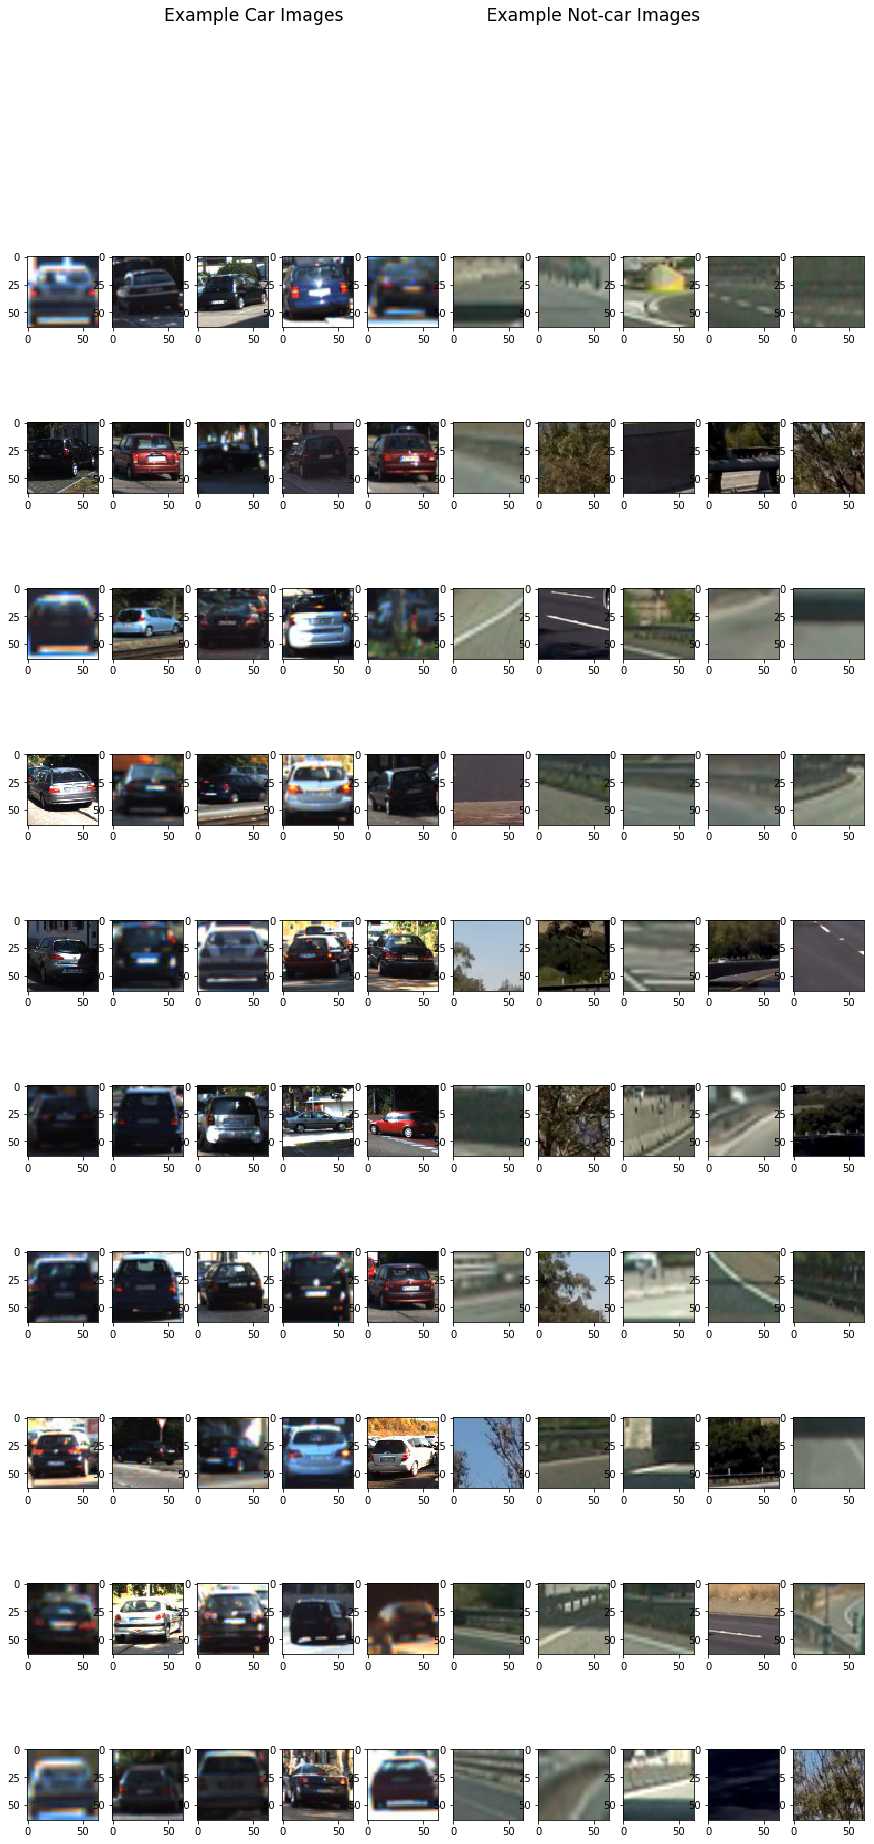

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import glob
import random

%matplotlib inline

PATH_VEHICLE_IMAGES = 'vehicles_smallset/'
PATH_NON_VEHICLE_IMAGES = 'non-vehicles_smallset/'
images = glob.glob(PATH_VEHICLE_IMAGES + '*/*.jpeg')
cars = []
for image in images:
    cars.append(image)
        
images = glob.glob(PATH_NON_VEHICLE_IMAGES + '*/*.jpeg')
notcars = []
for image in images:
    notcars.append(image)
    
example_car = mpimg.imread(cars[0])
image_shape = example_car.shape

print("Number of Car-Images: {}".format(len(cars)))
print("Number of Non-Car-Images: {}".format(len(notcars)))
print("Image data shape =", image_shape)

### Data exploration visualization code goes here.
f, ax = plt.subplots(10, 10, figsize=(15,30))
f.suptitle('Example Car Images                          Example Not-car Images', fontsize='xx-large')
cars_indicies = random.sample(range(0, len(cars)), 50)
notcars_indicies = random.sample(range(0, len(notcars)), 50)

for i in range(5):
    for j in range(10):
        example_car = mpimg.imread(cars[cars_indicies[10*i+j]])
        example_notcar = mpimg.imread(notcars[notcars_indicies[10*i+j]])
        ax[j][i].imshow(example_car)
        ax[j][i+5].imshow(example_notcar)

In [47]:
import cv2
from skimage.feature import hog

def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features
 
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       visualise=vis, feature_vector=feature_vec)
        return features
 
def convert_colorspace(image, cspace):
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)  
    return feature_image
    
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                           hist_bins=32, orient=9, pix_per_cell=8, 
                           cell_per_block=2, hog_channel=0,
                           spatial_feat = False, hist_feat = False, hog_feat = True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        file_features = []
        # apply color conversion if other than 'RGB'
        feature_image = convert_colorspace(image, cspace)  
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)    
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

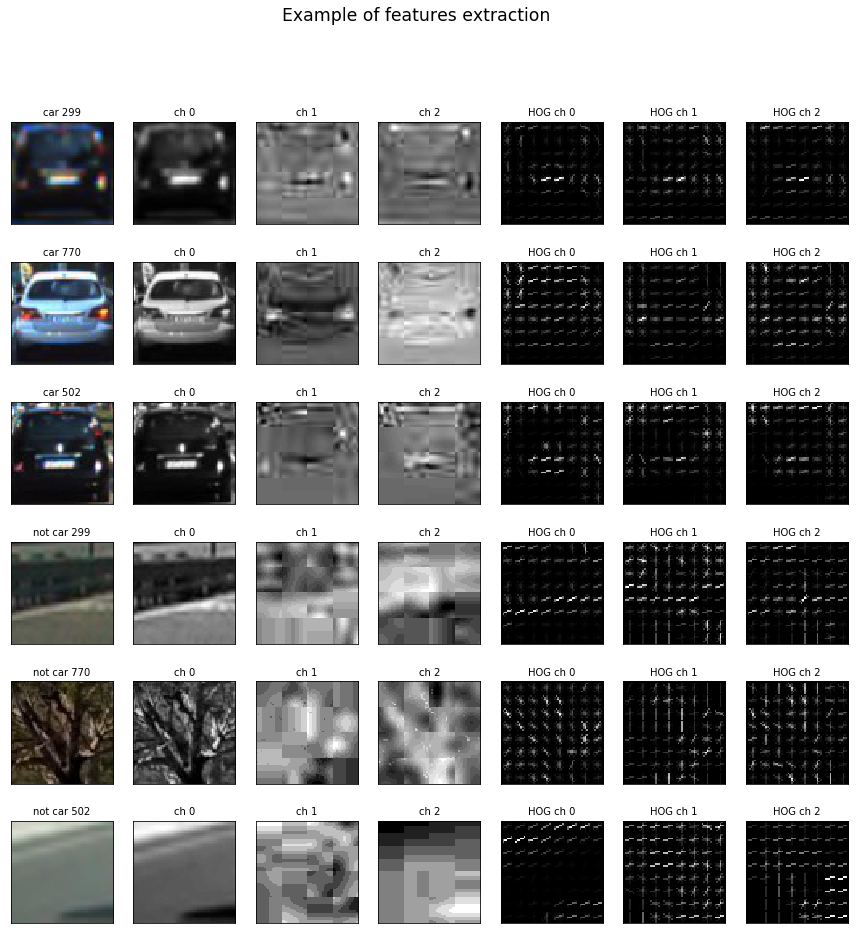

In [61]:
font_size=10
### Tuning of parameters

spatial = 32
histbin = 32
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_feat = False
hist_feat = False
hog_feat = True

### Data exploration visualization code goes here.
f, ax = plt.subplots(6, 7, figsize=(15,15))
f.suptitle('Example of features extraction', fontsize='xx-large')
cars_indicies = random.sample(range(0, len(cars)), 3)
notcars_indicies = random.sample(range(0, len(notcars)), 3)

for i in range(3):
    example_car = mpimg.imread(cars[cars_indicies[i]])
    image = np.copy(example_car)
    ax[i,0].imshow(image)
    ax[i,0].set_xticks([])
    ax[i,0].set_yticks([])
    title = "car {0}".format(cars_indicies[i])
    ax[i,0].set_title(title, fontsize=font_size)
    feature_image = convert_colorspace(image, colorspace)
    for ch in range(3):
        ax[i, ch+1].imshow(feature_image[:,:,ch], cmap='gray')
        ax[i, ch+1].set_xticks([])
        ax[i, ch+1].set_yticks([])
        title = "ch {0}".format(ch)
        ax[i, ch+1].set_title(title, fontsize=font_size)
    for ch in range(3):    
        features, hog_image = get_hog_features(feature_image[:,:,ch], orient, pix_per_cell, cell_per_block, vis=True)
        ax[i, ch+4].imshow(hog_image, cmap='gray')
        ax[i, ch+4].set_xticks([])
        ax[i, ch+4].set_yticks([])
        title = "HOG ch {0}".format(ch)
        ax[i, ch+4].set_title(title, fontsize=font_size)
    
for i in range(3):    
    example_notcar = mpimg.imread(notcars[notcars_indicies[i]])
    image = np.copy(example_notcar)
    ax[i+3, 0].imshow(image)
    ax[i+3, 0].set_xticks([])
    ax[i+3, 0].set_yticks([])
    title = "not car {0}".format(cars_indicies[i])
    ax[i+3, 0].set_title(title, fontsize=font_size)
    feature_image = convert_colorspace(image, colorspace)
    for ch in range(3):
        ax[i+3, ch+1].imshow(feature_image[:,:,ch], cmap='gray')
        ax[i+3, ch+1].set_xticks([])
        ax[i+3, ch+1].set_yticks([])
        title = "ch {0}".format(ch)
        ax[i+3, ch+1].set_title(title, fontsize=font_size)
    for ch in range(3):    
        features, hog_image = get_hog_features(feature_image[:,:,ch], orient, pix_per_cell, cell_per_block, vis=True)
        ax[i+3, ch+4].imshow(hog_image, cmap='gray')
        ax[i+3, ch+4].set_xticks([])
        ax[i+3, ch+4].set_yticks([])
        title = "HOG ch {0}".format(ch)
        ax[i+3, ch+4].set_title(title, fontsize=font_size)

In [63]:
import time
from sklearn import svm, grid_search, datasets
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

t=time.time()
car_features = extract_features(cars, cspace=colorspace, 
                        spatial_size=(spatial, spatial),
                        hist_bins=histbin, orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat = False, hist_feat = False, hog_feat = True)
notcar_features = extract_features(notcars, cspace=colorspace, 
                        spatial_size=(spatial, spatial),
                        hist_bins=histbin, orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat = False, hist_feat = False, hog_feat = True)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)   
print (X.shape)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
#parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
#svr = svm.SVC()
#svc = grid_search.GridSearchCV(svr, parameters)
#svc.fit(X_train, y_train)
#print('Best Parameters of SVC = ', svc.best_params_)
svc = LinearSVC()
svc.fit(X_train, y_train)
# Check the training time for the SVC
t=time.time()
#svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 100
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

4.67 Seconds to extract HOG features...
(2321, 1764)
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 1764
0.0 Seconds to train SVC...
Test Accuracy of SVC =  0.9634
My SVC predicts:  [ 0.  0.  1.  1.  0.  0.  1.  1.  1.  1.  1.  1.  0.  1.  1.  0.  0.  0.
  1.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.  1.  0.  1.  1.  1.  1.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  1.  0.  1.  1.  1.  0.  0.  1.  1.
  0.  1.  1.  1.  1.  0.  0.  1.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.
  1.  1.  1.  1.  0.  0.  1.  0.  0.  1.  1.  1.  1.  0.  1.  1.  1.  0.
  0.  0.  0.  1.  1.  1.  0.  0.  0.  0.]
For these 100 labels:  [ 0.  1.  1.  1.  0.  0.  1.  1.  1.  1.  1.  0.  1.  1.  1.  0.  0.  0.
  1.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.  1.  0.  1.  1.  1.  1.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  1.  1.  0.  0.  1.  1.
  0.  1.  1.  1.  1.  0.  0.  1.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.
  1.  1.  1.  1.  0.  0.  1.  0.  0.  1.  1.  1.  1.  0.  

## 2. Search for vehicles on image

In [64]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, pix_per_cell=8, 
                        cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    # Define an empty list to receive features
    img_features = []
    # Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    # Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Append features to list
        img_features.append(spatial_features)
    # Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        # Append features to list
        img_features.append(hist_features)
    # Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append features to list
        img_features.append(hog_features)

    # Return features
    return np.concatenate(img_features)

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    # Create an empty list to receive positive detection windows
    on_windows = []
    # Iterate over all windows in the list
    for window in windows:
        # Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        # Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        # Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        # Predict using your classifier
        prediction = clf.predict(test_features)
        # If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    # Return windows for positive detections
    return on_windows  

Number of windows: 130
0.42688 Seconds to process one image searching


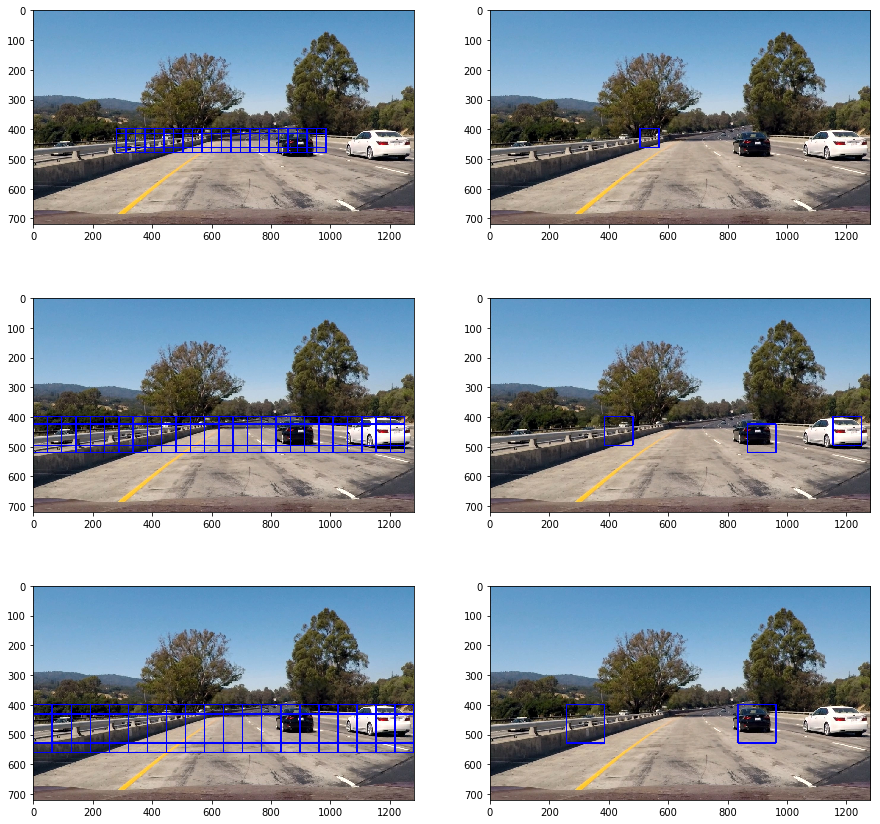

In [66]:
filenames = glob.glob('test_images/*.jpg') 
image = mpimg.imread(filenames[1])
img = np.copy(image)
windows = [0,0,0]
windows[0] = slide_window(img, x_start_stop=[280, 1000], y_start_stop=[400, 480], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.75))
windows[1] = slide_window(img, x_start_stop=[None, None], y_start_stop=[400, 528], 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.75))
windows[2] = slide_window(img, x_start_stop=[None, None], y_start_stop=[400, 560], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.75))
rects = []
rects.append(windows[0])
rects.append(windows[1])
rects.append(windows[2])
rectangles = [item for sublist in rects for item in sublist] 
print ('Number of windows:', len(rectangles))

f, ax = plt.subplots(3,2, figsize=(15,15))
t=time.time()
for i in range(3):
    out_img = draw_boxes(img, windows[i], color=(0, 0, 255), thick=3)
    ax[i][0].imshow(out_img)
    hot_windows = search_windows(img, windows[i], svc, X_scaler, color_space='YCrCb', 
                                 spatial_size=(32, 32), hist_bins=32, 
                                 hist_range=(0, 256), orient=9, 
                                 pix_per_cell=8, cell_per_block=2, 
                                 hog_channel=0, spatial_feat=False, 
                                 hist_feat=False, hog_feat=True)
    out_img = draw_boxes(img, hot_windows, color=(0, 0, 255), thick=3)
    ax[i][1].imshow(out_img)
    
print(round(time.time()-t, 5), 'Seconds to process one image searching')    

## 3. Implement a sliding-window technique and use your trained classifier to search for vehicles in images

In [77]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
              cell_per_block, spatial_size, hist_bins):
    # array of rectangles where cars were detected
    rectangles = []
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_colorspace(img_tosearch, cspace='YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, 
                                     (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_features = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            #hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            #hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            #hog_features = np.hstack((hog_feat1))
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            # Get color features
            #spatial_features = bin_spatial(subimg, size=spatial_size)
            #hist_features = color_hist(subimg, nbins=hist_bins)
            #features = np.concatenate((spatial_features, hist_features, hog_features))
            # Scale features and make a prediction
            test_features = X_scaler.transform(hog_features.reshape(1, -1))  
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),
                                  (xbox_left+win_draw,ytop_draw+win_draw+ystart))) 
    return rectangles

[[ 2.44310452  5.5589      1.29713542 ...,  1.4309681  -0.16592176
  -0.43335595]]
[[ 3.42355549  0.10739922 -0.39991399 ...,  0.52238337  2.44240953
   0.34671861]]
[[ 2.42934183  0.31115848 -0.37111218 ..., -0.62853811 -0.49638231
  -0.37936925]]
[[ 0.99944463  2.14904924  3.83332761 ...,  0.36046041  0.53901254
   1.67451199]]
[[-0.78571893  1.4982967   9.55861174 ...,  1.11540364  3.1428162
   0.48396959]]
[[ 0.26941935  0.3217258  -0.34696014 ...,  0.52343611  0.45143495
  -0.16863084]]
[[ 0.17330738  0.47300326  0.54761945 ...,  0.11669747  1.28219821
   1.85101108]]
[[-0.54618524 -0.43822942  1.26369628 ..., -0.0781565  -0.21526147
   0.23075118]]
[[ 1.45227571  5.56970528  0.37655305 ..., -0.51853738 -0.58265037
  -0.43335595]]
[[ 0.19642956 -0.59658214 -0.73117766 ...,  3.02115906  2.48581637
   0.56587491]]
[[ 0.40776248  0.65504861  1.54115358 ..., -0.02463172 -0.58265037
  -0.22731592]]
[[ 2.57411408  1.22461626  1.20830196 ..., -0.51765161 -0.58265037
  -0.40193046]]
[[-0.

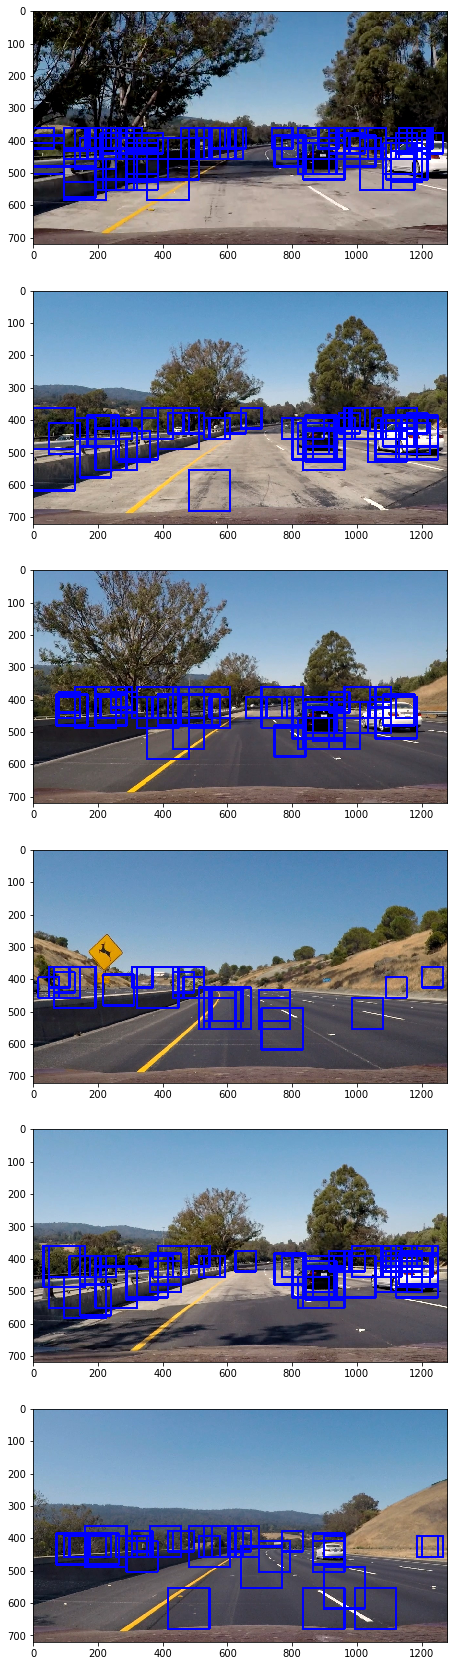

In [78]:
filenames = glob.glob('test_images/*.jpg') 

spatial_size = (32, 32)
hist_bins = 32
orient = 9
pix_per_cell = 8
cell_per_block = 2
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb

f, ax = plt.subplots(len(filenames),1, figsize=(15,30))
for i, filename in enumerate(filenames):
    rects = []
    t=time.time()
    image = mpimg.imread(filename)
    img = np.copy(image)
    ystart = 360
    ystop = 480
    scale = 1
    rects.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                        cell_per_block, spatial_size, hist_bins))
    ystart = 360
    ystop = 600
    scale = 1.5
    rects.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                        cell_per_block, spatial_size, hist_bins))
    ystart = 360
    ystop = 720
    scale = 2
    rects.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                        cell_per_block, spatial_size, hist_bins))
    rectangles = [item for sublist in rects for item in sublist] 
    out_img = draw_boxes(img, rectangles, color=(0, 0, 255), thick=6)
    ax[i].imshow(out_img)
    print(round(time.time()-t, 5), 'Seconds to process one image searching')

In [165]:
def multiscale_search(image):
    spatial_size = (32, 32)
    hist_bins = 32
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    rects = []
    img = np.copy(image)
    ystart = 360
    ystop = 480
    scale = 1
    rects.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                        cell_per_block, spatial_size, hist_bins))
    ystart = 360
    ystop = 600
    scale = 1.5
    rects.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                        cell_per_block, spatial_size, hist_bins))
    ystart = 360
    ystop = 720
    scale = 2
    rects.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                        cell_per_block, spatial_size, hist_bins))
    rectangles = [item for sublist in rects for item in sublist] 
    return rectangles

def add_heat(image, bbox_list, heatmap = None):
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

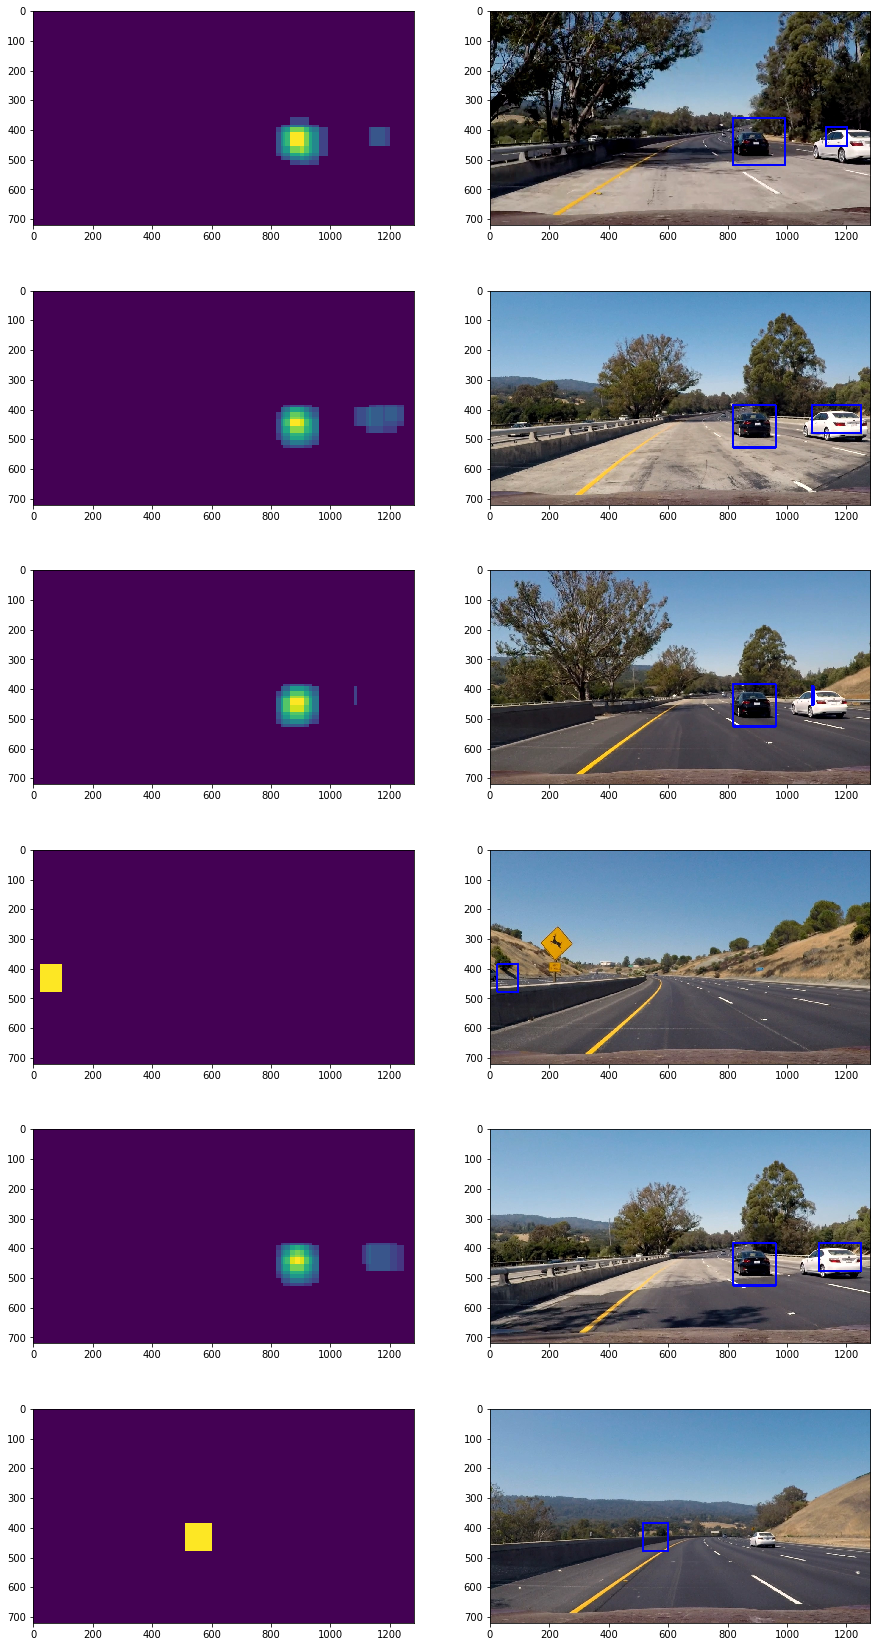

In [168]:
from scipy.ndimage.measurements import label

f, ax = plt.subplots(len(filenames),2, figsize=(15,30))
for i, filename in enumerate(filenames):
    img = mpimg.imread(filename)
    hot_windows = multiscale_search(img)   
    # Add heat to each box in box list
    heat = add_heat(img, hot_windows)   
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    ax[i][0].imshow(heatmap)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    #draw_img = draw_boxes(draw_img, hot_windows, color=(0, 0, 255), thick=6)
    ax[i][1].imshow(draw_img)

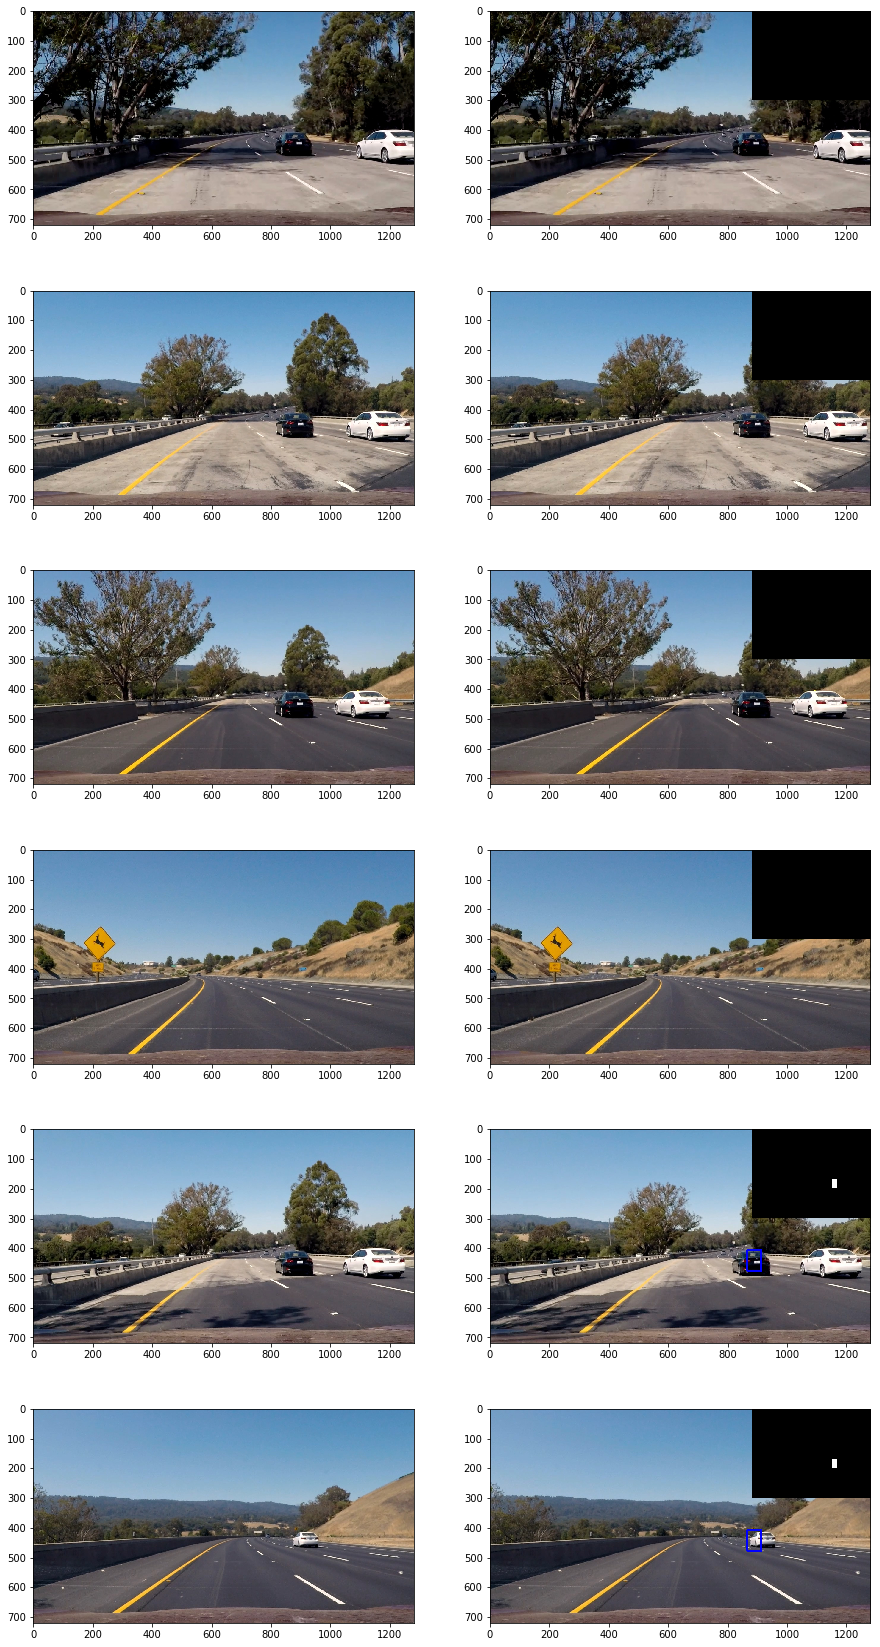

In [169]:
total_hot_windows = []

def show_heatmap(image, heatmap, width, height):
    heatmap_cpy = np.copy(50 * heatmap)
    # Normolize the heatmap when displaying    
    heatmap_cpy = np.clip(heatmap_cpy, 0, 255)
    # Resize the image
    resized_heatmap = cv2.resize(heatmap_cpy, (width, height), interpolation=cv2.INTER_AREA)
    # Compose the 3 channel Heatmap
    rgb_heatmap = cv2.merge([resized_heatmap, resized_heatmap, resized_heatmap])
    # Add Heatmap to the Image
    image[0:height,image.shape[1]-width:image.shape[1]] = rgb_heatmap
    return image
    
    
def pipeline(image, heat = None):
    global total_hot_windows
    heatmap_vis = True
    hot_windows = multiscale_search(image)
    total_hot_windows.append(hot_windows)
    if (len(total_hot_windows) > 15):
        total_hot_windows = total_hot_windows[1:]
    stack_hot_windows = sum(total_hot_windows, [])
    # Add heat to each box in box list
    heatmap = add_heat(image, stack_hot_windows)  
    # Apply threshold to help remove false positives
    heatmap = apply_threshold(heatmap,50)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    if (heatmap_vis):
        draw_img = show_heatmap(draw_img, heatmap, 400,300)
    return draw_img

def process_image(image):
    result = pipeline(image)
    return result

f, ax = plt.subplots(len(filenames),2, figsize=(15,30))
for i, filename in enumerate(filenames):
    image = mpimg.imread(filename)
    ax[i][0].imshow(image)
    result = process_image(image)
    ax[i][1].imshow(result)

## 4. Run your pipeline on a video stream

In [170]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [173]:
project_output = 'test_video_out.mp4'
clip1 = VideoFileClip("test_video.mp4")
project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:44<00:01,  1.17s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 50 s, sys: 84 ms, total: 50.1 s
Wall time: 45.8 s


In [174]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

In [175]:
project_output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [24:33<00:01,  1.17s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 27min 27s, sys: 4.44 s, total: 27min 31s
Wall time: 24min 34s


In [44]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))